In [1]:
import jax
import equinox as eqx
from IPython.display import display, Audio

from src.tasks.model import (
    build_linoss,
    build_linoss_spectral,
    build_linoss_noise_cancellation,
)
from tasks.dataloader import get_vb_demand_dataloaders
from tasks.util import create_spec
from tasks.train_util import load_for_inference

/mnt/d/dev/linaxSE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/mnt/d/dev/linaxSE/.venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:8283: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/tmp/ipykernel_19330/1998608391.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  create_spec(waveform=x[i].squeeze(), sample_rate=16000, title="Noisy Input").show()
/tmp/ipykernel_19330/1998608391.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  create_spec(waveform=y[i].squeeze(), sample_rate=16000, title="Target").show()


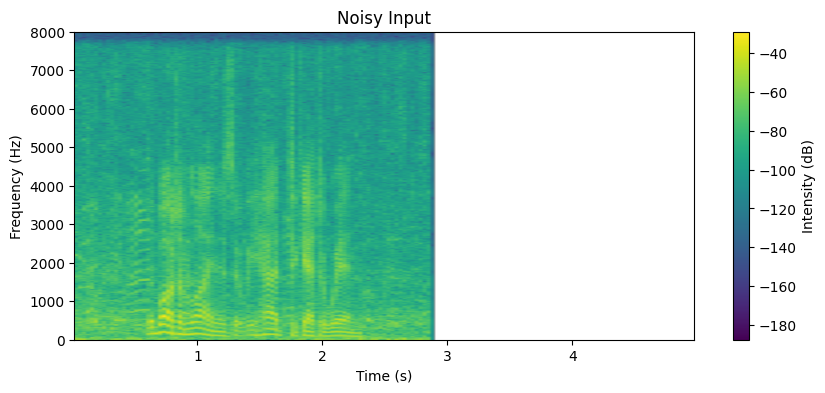

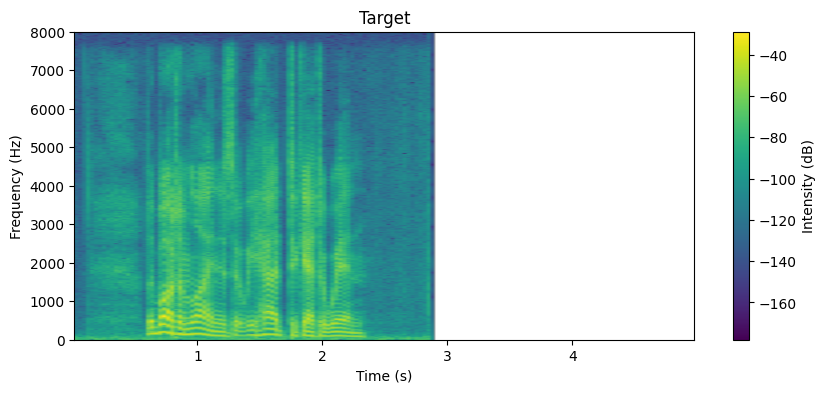

In [2]:
train_loader, test_loader = get_vb_demand_dataloaders(
    batch_size=1, shuffle_test_data=True, sample_length=16000 * 5
)
random_batch = next(iter(test_loader))
x = random_batch["noisy"].numpy()
y = random_batch["clean"].numpy()
mask = random_batch["mask"].numpy()

for i in range(x.shape[0]):
    create_spec(waveform=x[i].squeeze(), sample_rate=16000, title="Noisy Input").show()
    create_spec(waveform=y[i].squeeze(), sample_rate=16000, title="Target").show()
    display(
        Audio(x[i].squeeze(), rate=16000, autoplay=False, normalize=True),
        Audio(y[i].squeeze(), rate=16000, autoplay=False, normalize=True),
    )

In [4]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
model = build_linoss(subkey)
model_state = eqx.nn.State(model=model)

inference_model, model_state = load_for_inference(
    model=model,
    state=model_state,
    key=key,
    ckpt_path="checkpoints/ckpt_step_63000.eqx",
)

In [5]:
pred_y, model_state = jax.vmap(
    inference_model,
    axis_name="batch",
    in_axes=(0, None, 0),
    out_axes=(0, None),
)(x, model_state, jax.random.split(key, x.shape[0]))

/tmp/ipykernel_19330/1435301084.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  create_spec(waveform=pred_y[0].squeeze(), sample_rate=16000, title="Model Prediction").show()


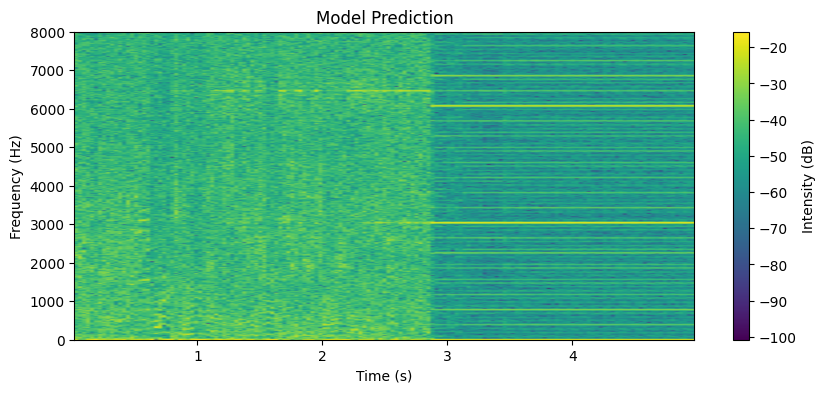

In [6]:
create_spec(waveform=pred_y[0].squeeze(), sample_rate=16000, title="Model Prediction").show()
display(Audio(pred_y[0].squeeze(), rate=16000, autoplay=False, normalize=True))